In [47]:
import plumed
import matplotlib.pyplot as plt
import os
import MDAnalysis
import mdtraj as md 
import numpy as np
import math
import pyemma
from os import getcwd as wd
from os import chdir as cd
import pandas as pd
from IPython.display import Image
import seaborn as sns
def extract_files(dr,root,n,end):
    l=[]
    if dr == None:
        dr = os.getcwd()
    if end == None:
        targets = [dr+"/"+str(root)+"{}".format(str(j)) for j in range(n)]
    else:
        targets = [dr+"/"+str(root)+"{}".format(str(j))+end for j in range(n)]
        
    for i in targets:
            for k in [dr+"/"+f for f in os.listdir(dr) if os.path.isfile(os.path.join(dr,f))]:
                if i == k: l.append(i)
    return l   

def plotmed(cv):
   
    df = [plumed.read_as_pandas(i) for i in cv]
    arr = [i.to_numpy() for i in df]
    cat = np.concatenate(arr,axis=0)
    cat[~np.isfinite(cat)] = 0
    title = df[0].columns.tolist()
    
    fig,ax = plt.subplots(1,1,figsize=(10,10))
    pyemma.plots.plot_free_energy(*cat[:,1:3].T,ax=ax)
    ax.set_xlabel("{}".format(title[1]))
    ax.set_ylabel("{}".format(title[2]))
    ax.set_title("S tells you where you are in the path, Z tells you how far away you are from the nearest guess frame")
    
    if len(cv)>=5:
        fig,ax = plt.subplots(1,1,figsize=(10,10))
        pyemma.plots.plot_free_energy(*cat[:,3:5].T,ax=ax)
        ax.set_xlabel("{}".format(title[3]))
        ax.set_ylabel("{}".format(title[4]))
   
    for i,t in enumerate(title):
        plt.figure()
        for j in df:
            j.iloc[:,i].plot(xlabel="Time",ylabel=t)
           
    fig,ax=plt.subplots(len(title),1, figsize=(8,2.5*len(title)))
    for i,(t,ax) in enumerate(zip(title,ax.flat)):
        sns.kdeplot(cat[:,i],ax=ax)
        ax.set_xlabel(f"{t}")
        plt.tight_layout()
   
    return df,arr,cat



Text(0.5, 1.0, 'Distribution of CV Z - TICA space, Tells you how far away from the path you are')

<Figure size 432x288 with 0 Axes>

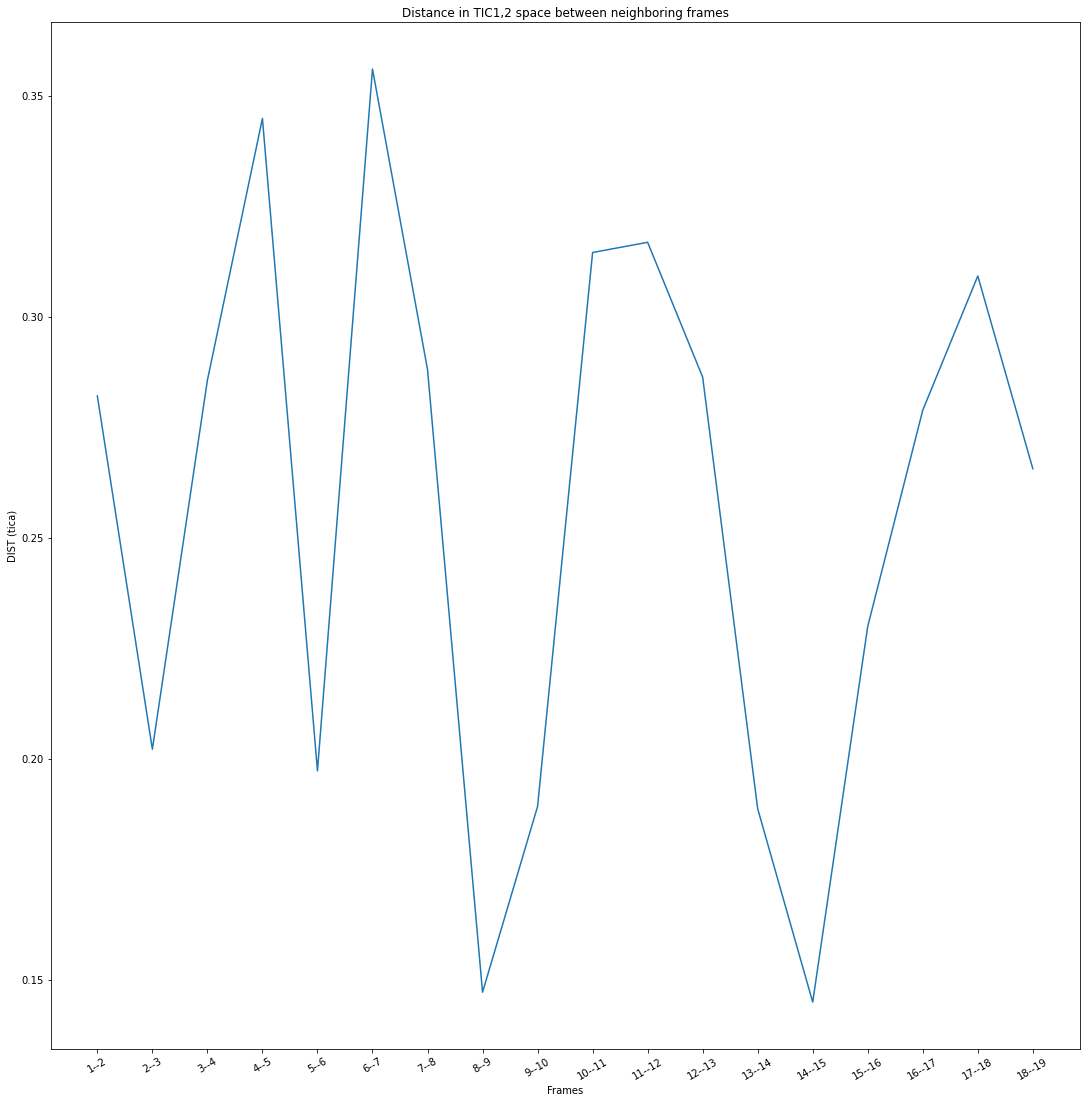

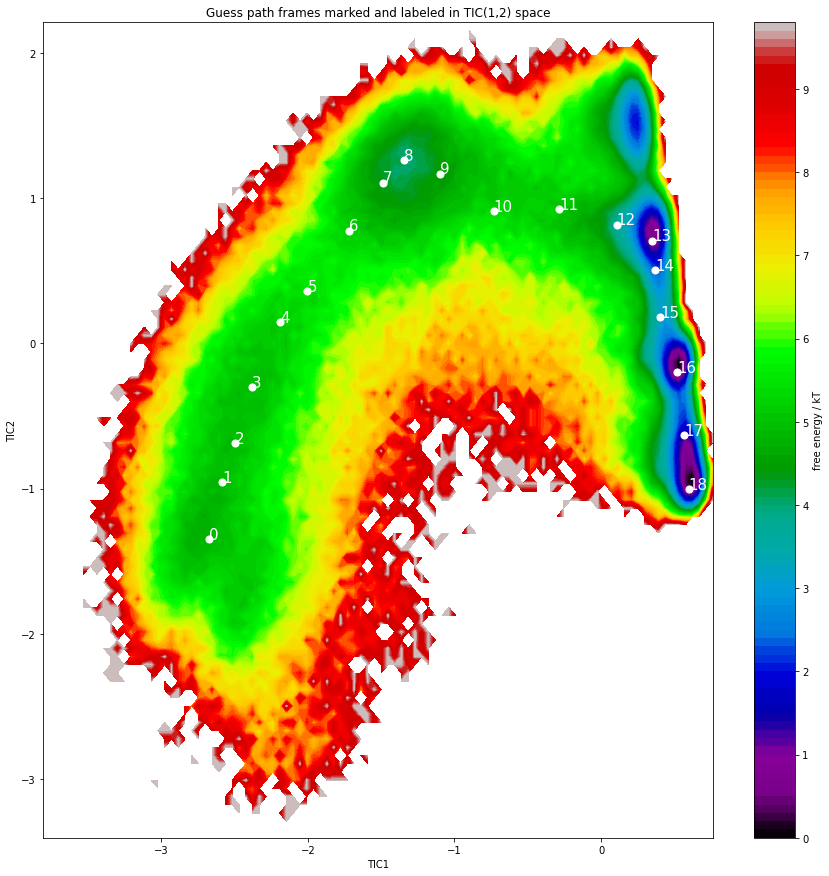

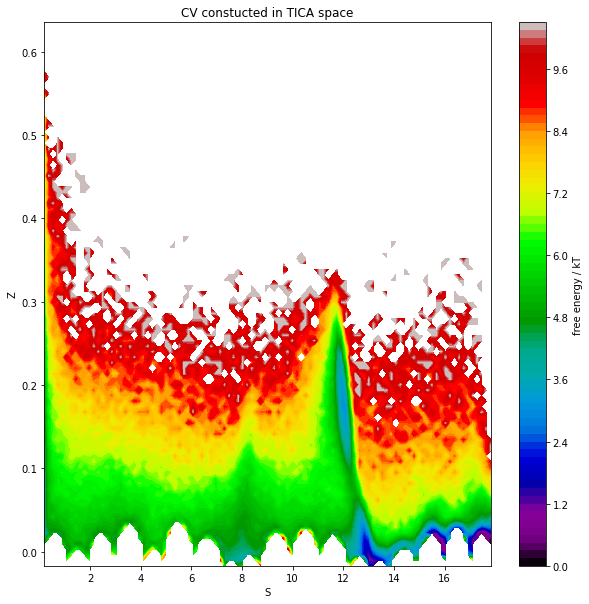

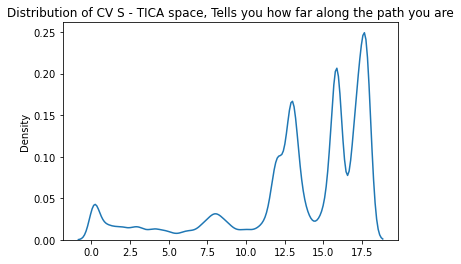

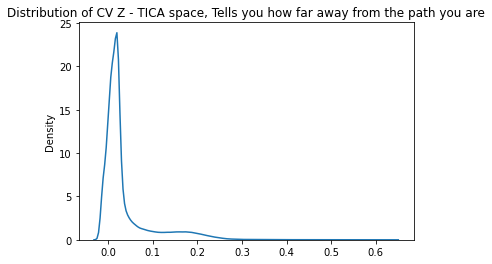

In [49]:
"""now we want to make a PCV of the ntail.xd simulation at 400K

If we want to make a PCV that makes sense in the context of the free energy surface created
by a dimensionality reduction method or a set of raw features, we must create PCVs that live
in the space of that data. This includes features like RMSD"""



"""Here I define the plumed functions from the documentation to calculate PCV's S and Z
***PVC's S and Z and introduced and defined in the backround notebook***


"""

#define plumed functions
def rmsd(x1,x2):
    if len(x1)==len(x2):
        return np.sqrt(np.sum((x1-x2)**2)/len(x1))
        
def lam(xi):
    num = 2.3*(len(xi)-1)
    denom = 0
    for i in range(len(xi)-1):
        denom += rmsd(xi[i],xi[i+1])
    return num/denom
        
def S(x,xi,lam):
    return np.sum(np.array([(j+1)*np.exp(-lam*rmsd(x,i)) for j,i in enumerate(xi)]))/np.sum(
        np.array([np.exp(-lam*rmsd(x,i)) for i in xi]))

def Z(x,xi,lam):
    return (-1/lam)*np.log10(np.sum(np.array([np.exp(-lam*rmsd(x,i)) for i in xi])))


#Here I'm going to construct a path in TICA space and use the values of tic 1 and 2 as inputs to CONSTRUCT the
# actual path collective variables, S and Z

p = np.load("/home/t/IDP_MSM/NtailXD_Data/dist_sa_data/dist_sa_tics_lag30.npy")
path_frames = np.load("/home/t/chem101/pcv/marvel-2/ntxd/path_frames.npy")
p_red = p[:,:2]
plt.figure()
tica_displacements = []
for i in range(len(path_frames)-1):
    tica_displacements.append(rmsd(p_red[path_frames[i]],p_red[path_frames[i+1]]))

fig,ax = plt.subplots(1,1,figsize=(15,15))
ax.plot(np.arange(1,len(tica_displacements)+1),tica_displacements)
ax.set_xticks(np.arange(1,1+len(tica_displacements)),[f"{i+1}--{i+2}" for i in range(len(tica_displacements))],rotation =30)
plt.tight_layout()
ax.set_title("Distance in TIC1,2 space between neighboring frames")
ax.set_ylabel("DIST (tica)")
ax.set_xlabel("Frames")



fig,ax = plt.subplots(1,1,figsize=(15,15))
pyemma.plots.plot_free_energy(*p_red.T,ax=ax)
ax.scatter(*p_red[path_frames].T,c="white",s=50)
for j,c in enumerate(path_frames):
    ax.annotate(text=f"{j}",xy=(p_red[c]),size=15,color="white")
ax.set_xlabel("TIC1")
ax.set_ylabel("TIC2")
ax.set_title("Guess path frames marked and labeled in TIC(1,2) space")

xi = [p_red[i] for i in path_frames]
lam_ = lam(xi)
pathS = [S(x,xi,lam_) for x in p_red]
pathZ = [Z(x,xi,lam_) for x in p_red]

fig,ax = plt.subplots(1,1,figsize=(10,10))
pyemma.plots.plot_free_energy(pathS,pathZ,ax=ax)
ax.set_xlabel("S")
ax.set_ylabel("Z")
ax.set_title("CV constucted in TICA space")
plt.figure()
sns.kdeplot(pathS)
plt.title("Distribution of CV S - TICA space, Tells you how far along the path you are")

plt.figure()
sns.kdeplot(pathZ)
plt.title("Distribution of CV Z - TICA space, Tells you how far away from the path you are")

##we see that the S CV has a distribution that represents each of our clusters in the path.

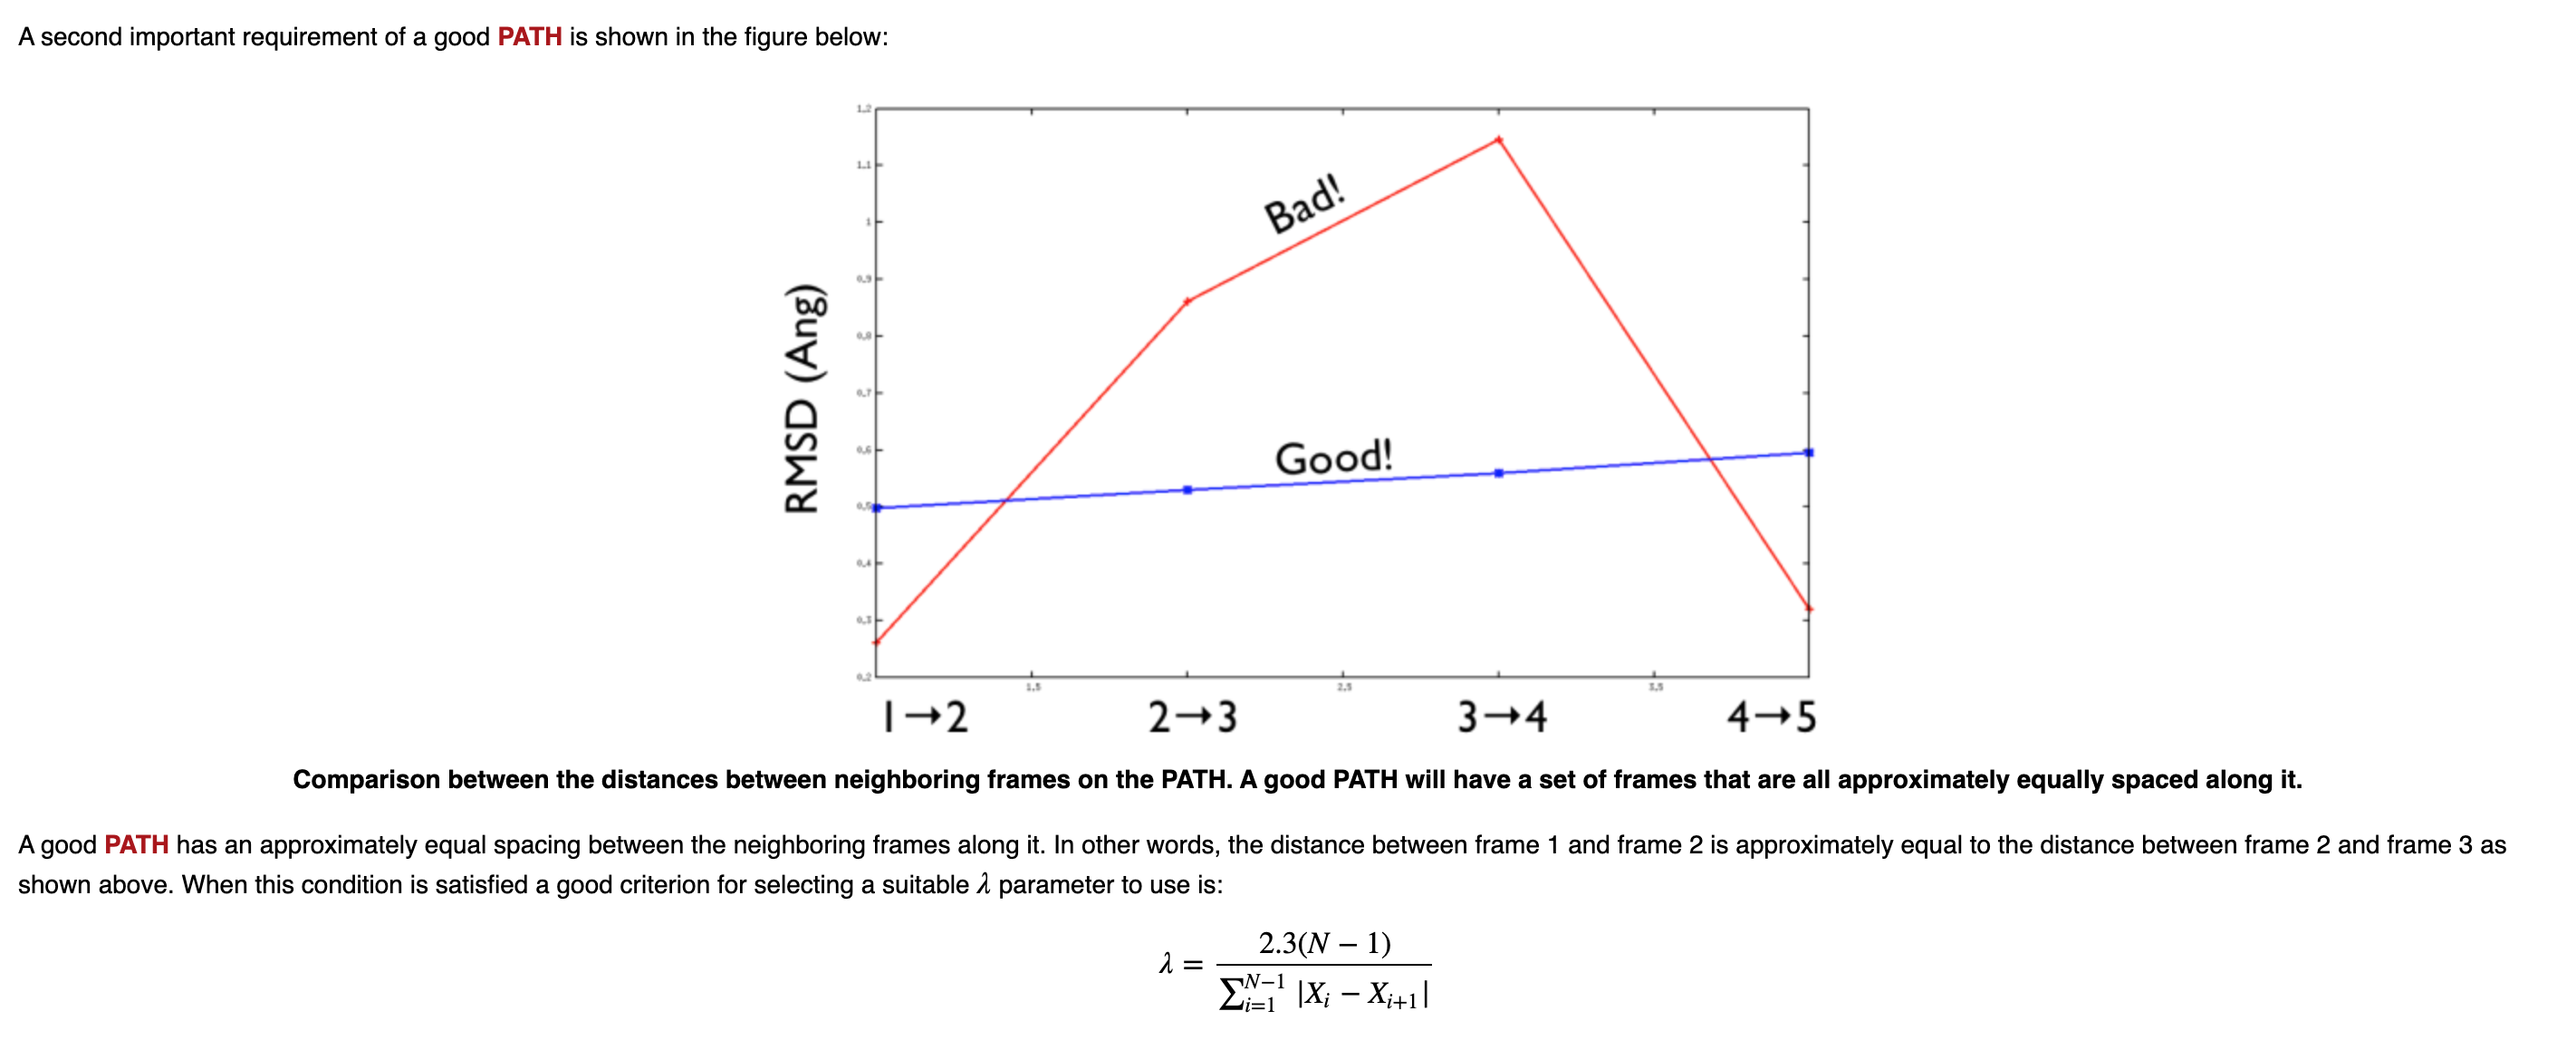

In [50]:
"""We now move onto calcululating the PCV's S and Z using the rmsd between each frame of our guess path and the 
instantaneous frame of the simulation

Before calculating S and Z we need to calculate the rmsd between the ith and i + 1 frame of our guess path
in order to calculate the lambda parameter used in both S and Z"""

Image(filename="/home/t/Downloads/Screen Shot 2022-03-14 at 8.46.31 PM.png")

In [51]:
trj = md.load("/home/t/chem101/pcv/marvel-2/ntxd/ntxd.long_path.pdb")
trj.center_coordinates()
rmsds = []
for i in range(len(trj)-1):
    r = md.rmsd(trj[i],trj[i+1])
    rmsds.append(r)

LAMBDA:2.551897211365068


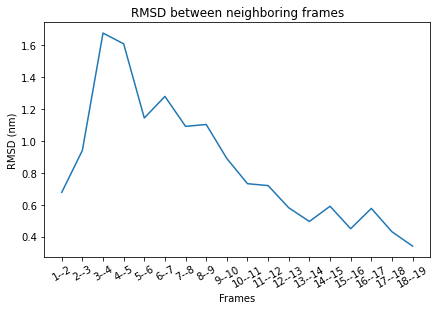

In [52]:
"""This plots tells us that our guess path frames are not evenly spaced in rmsd space
However, we know these frames are significant in our folding pathway. So, we calculate anyway.
Ideally, we want this plot to look like the above figure,
the folding pathway determined from the MSM is not well decribed with the rmsd metric"""

plt.plot(np.arange(1,len(rmsds)+1),rmsds)
plt.xticks(np.arange(1,1+len(rmsds)),[f"{i+1}--{i+2}" for i in range(len(rmsds))],rotation =30)
plt.tight_layout()
plt.title("RMSD between neighboring frames")
plt.ylabel("RMSD (nm)")
plt.xlabel("Frames")

lam_rmsd = (2.3*(len(rmsds)-1))/np.sum(np.array(rmsds))
print(f"LAMBDA:{lam_rmsd}")

In [39]:
%%bash
#lets do the same thing, except this time we use the rmsd between the instantaneous frame 
#and each frame in our guess path as the input to constuct the PCVs S and Z

cd ./ntxd
# create PLUMED input file
rm -rf colvar_path_rmsd_final

cat > "plumed.dat" << EOF
# Activate MOLINFO functionalities
#MOLINFO STRUCTURE=../../data/diala/dialaA.pdb

path: PATH REFERENCE=ntxd.long_path.pdb TYPE=OPTIMAL LAMBDA=2.55189

PRINT ARG=path.spath,path.zpath STRIDE=1 FILE=colvar_path_rmsd_final FMT=%12.8f
EOF

plumed driver --plumed plumed.dat --mf_pdb /home/t/chem101/pcv/marvel-2/ntxd/trunc_traj.pdb




DRIVER: Found molfile format trajectory pdb with name /home/t/chem101/pcv/marvel-2/ntxd/trunc_traj.pdb
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: Unknown) compiled on Feb 23 2022 at 09:52:46
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/t/anaconda3/envs/plumed/lib/plumed
PLUMED: For installed feature, see /home/t/anaconda3/envs/plumed/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1138
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action PATH
PLUMED:   with label path
PLUMED:   found 19 configurations in file ntxd.long_path.pdb
PLUMED:   found 1138 atoms in input 
PLUMED:   with indices : 
PLUMED: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 
PLUMED: 26 27 28 29 30 

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/t/anaconda3/envs/plumed/lib/libplumedKernel.so" +++


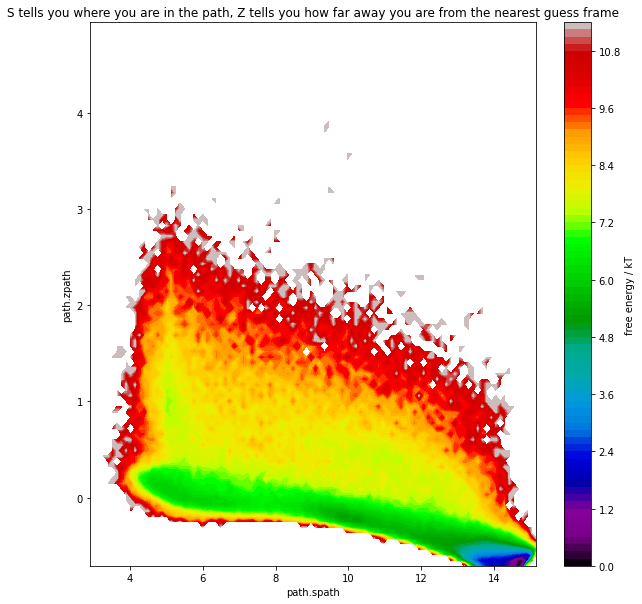

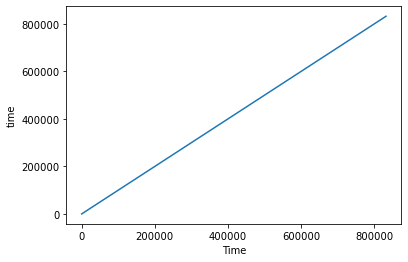

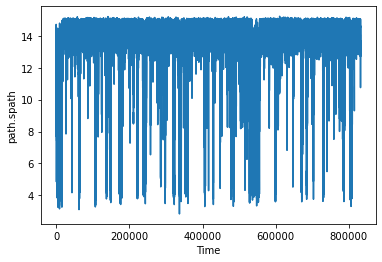

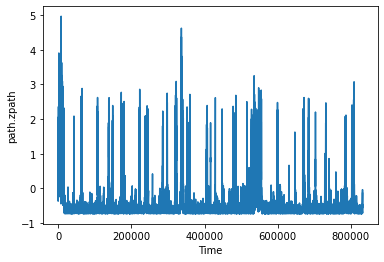

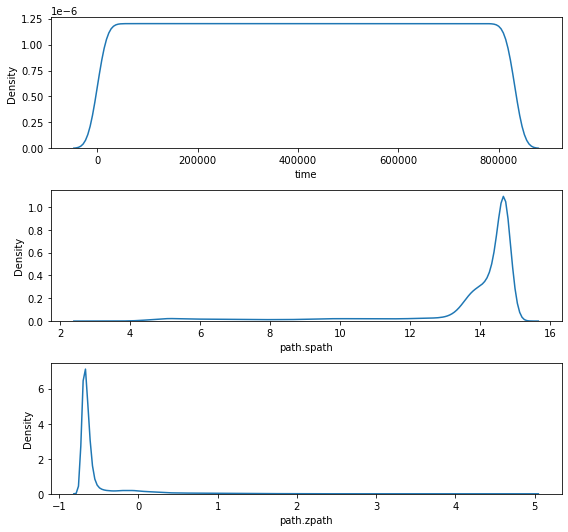

In [42]:
#the CV Z can be negative i.e "above"  or "below" path based on feature space
##the CV does not effectivly differentiate between different states

_,_,_=plotmed(["/home/t/chem101/pcv/marvel-2/ntxd/colvar_path_rmsd_final"])

LAMBDA:3.339495164968354


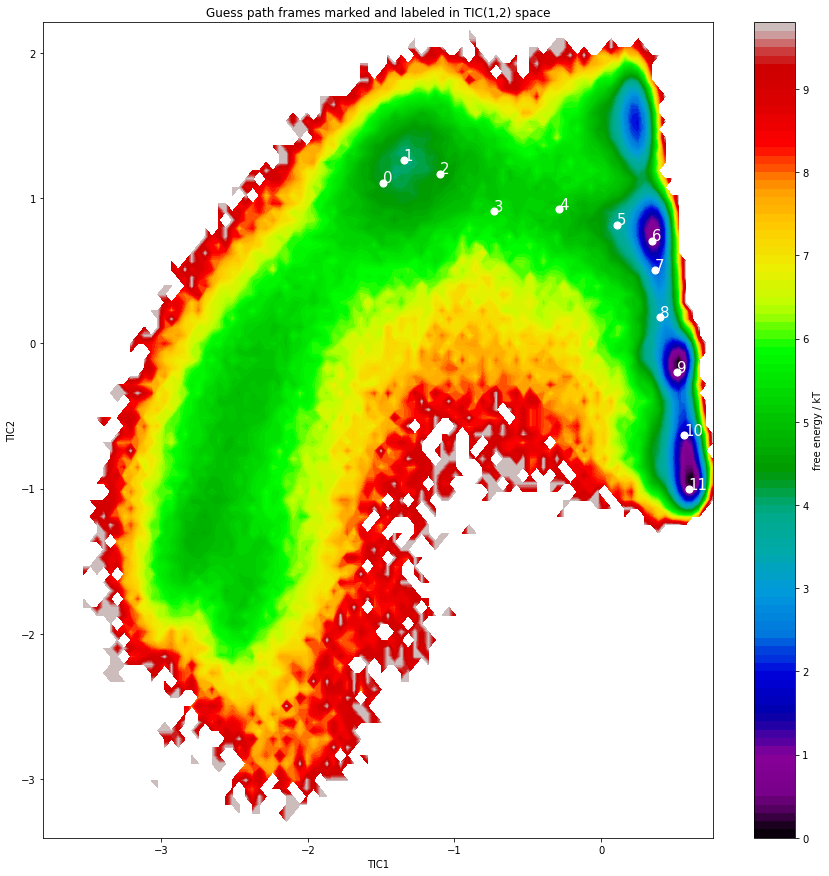

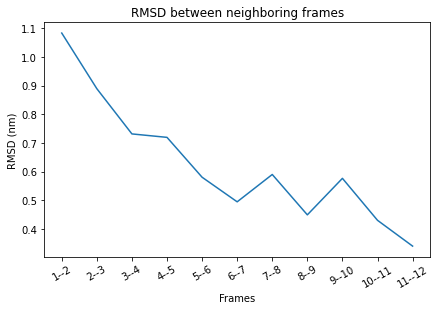

In [55]:
##lets try calculating the rmsd_path CVs again with a shortened path
short_path_frames = path_frames[-12:]
fig,ax = plt.subplots(1,1,figsize=(15,15))
pyemma.plots.plot_free_energy(*p_red.T,ax=ax)
ax.scatter(*p_red[short_path_frames].T,c="white",s=50)
for j,c in enumerate(short_path_frames):
    ax.annotate(text=f"{j}",xy=(p_red[c]),size=15,color="white")
ax.set_xlabel("TIC1")
ax.set_ylabel("TIC2")
ax.set_title("Guess path frames marked and labeled in TIC(1,2) space")

trj_shrt = md.load("/home/t/chem101/pcv/marvel-2/ntxd/ntxd.short_path.pdb")
trj_shrt.center_coordinates()
rmsds_ = []
for i in range(len(trj_shrt)-1):
    r = md.rmsd(trj_shrt[i],trj_shrt[i+1])
    rmsds_.append(r)
    
    
plt.figure()
plt.plot(np.arange(1,len(rmsds_)+1),rmsds_)
plt.xticks(np.arange(1,1+len(rmsds_)),[f"{i+1}--{i+2}" for i in range(len(rmsds_))],rotation =30)
plt.tight_layout()
plt.title("RMSD between neighboring frames")
plt.ylabel("RMSD (nm)")
plt.xlabel("Frames")

lam_rmsd = (2.3*(len(rmsds_)-1))/np.sum(np.array(rmsds_))
print(f"LAMBDA:{lam_rmsd}")

In [ ]:
#lets calculate the rmsd PCVs with the shortened path using plumed

In [57]:
%%bash
#lets do the same thing, except this time we use the rmsd between the instantaneous frame 
#and each frame in our guess path as the input to constuct the PCVs S and Z

cd ./ntxd
# create PLUMED input file
rm -rf colvar_path_rmsd_short_final

cat > "plumed.dat" << EOF
# Activate MOLINFO functionalities
#MOLINFO STRUCTURE=../../data/diala/dialaA.pdb

path: PATH REFERENCE=/home/t/chem101/pcv/marvel-2/ntxd/ntxd.short_path.pdb TYPE=OPTIMAL LAMBDA=3.33949516

PRINT ARG=path.spath,path.zpath STRIDE=1 FILE=colvar_path_rmsd_short_final FMT=%12.8f
EOF

plumed driver --plumed plumed.dat --mf_pdb /home/t/chem101/pcv/marvel-2/ntxd/trunc_traj.pdb




DRIVER: Found molfile format trajectory pdb with name /home/t/chem101/pcv/marvel-2/ntxd/trunc_traj.pdb
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: Unknown) compiled on Feb 23 2022 at 09:52:46
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/t/anaconda3/envs/plumed/lib/plumed
PLUMED: For installed feature, see /home/t/anaconda3/envs/plumed/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1138
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action PATH
PLUMED:   with label path
PLUMED:   found 12 configurations in file /home/t/chem101/pcv/marvel-2/ntxd/ntxd.short_path.pdb
PLUMED:   found 1138 atoms in input 
PLUMED:   with indices : 
PLUMED: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 2

In [58]:
!find $(pwd) | grep colvar_path_rmsd_short_final

/home/t/chem101/pcv/marvel-2/ntxd/colvar_path_rmsd_short_final


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/t/anaconda3/envs/plumed/lib/libplumedKernel.so" +++


([            time  path.spath  path.zpath
  0            0.0    7.163690    0.078710
  1            1.0    7.351399    0.140222
  2            2.0    7.163938    0.069637
  3            3.0    7.597018    0.141217
  4            4.0    7.620818    0.082210
  ...          ...         ...         ...
  831696  831696.0    7.472164    0.081927
  831697  831697.0    7.283845    0.119000
  831698  831698.0    7.064683    0.114506
  831699  831699.0    7.309200    0.102205
  831700  831700.0    7.398862    0.096119
  
  [831701 rows x 3 columns]],
 [array([[0.00000000e+00, 7.16369000e+00, 7.87099000e-02],
         [1.00000000e+00, 7.35139866e+00, 1.40221940e-01],
         [2.00000000e+00, 7.16393810e+00, 6.96373500e-02],
         ...,
         [8.31698000e+05, 7.06468305e+00, 1.14505870e-01],
         [8.31699000e+05, 7.30920036e+00, 1.02204580e-01],
         [8.31700000e+05, 7.39886227e+00, 9.61190400e-02]])],
 array([[0.00000000e+00, 7.16369000e+00, 7.87099000e-02],
        [1.00000000e+0

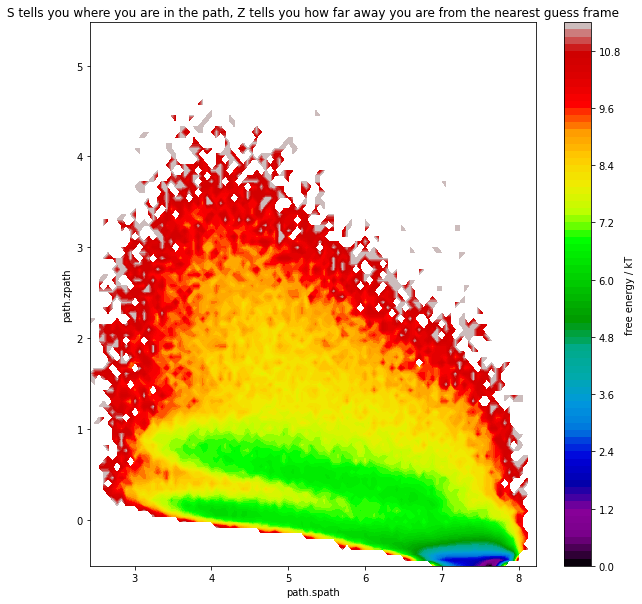

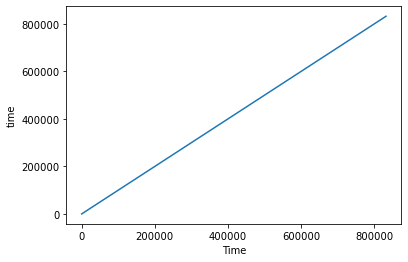

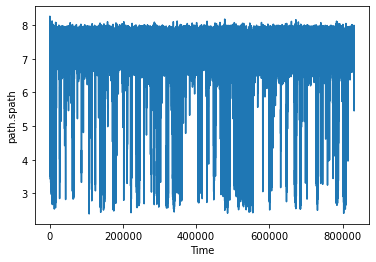

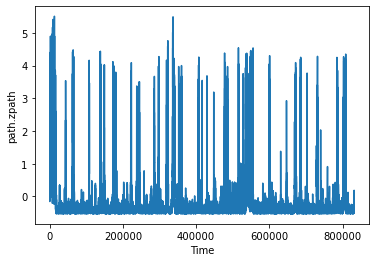

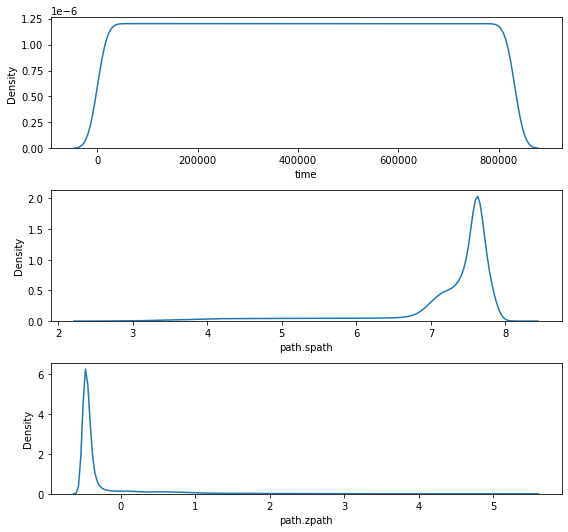

In [60]:
#here we plot the data for the shortened path calculation 
plotmed(["/home/t/chem101/pcv/marvel-2/ntxd/colvar_path_rmsd_short_final"])

Text(0.5, 0, 'Z')

<Figure size 432x288 with 0 Axes>

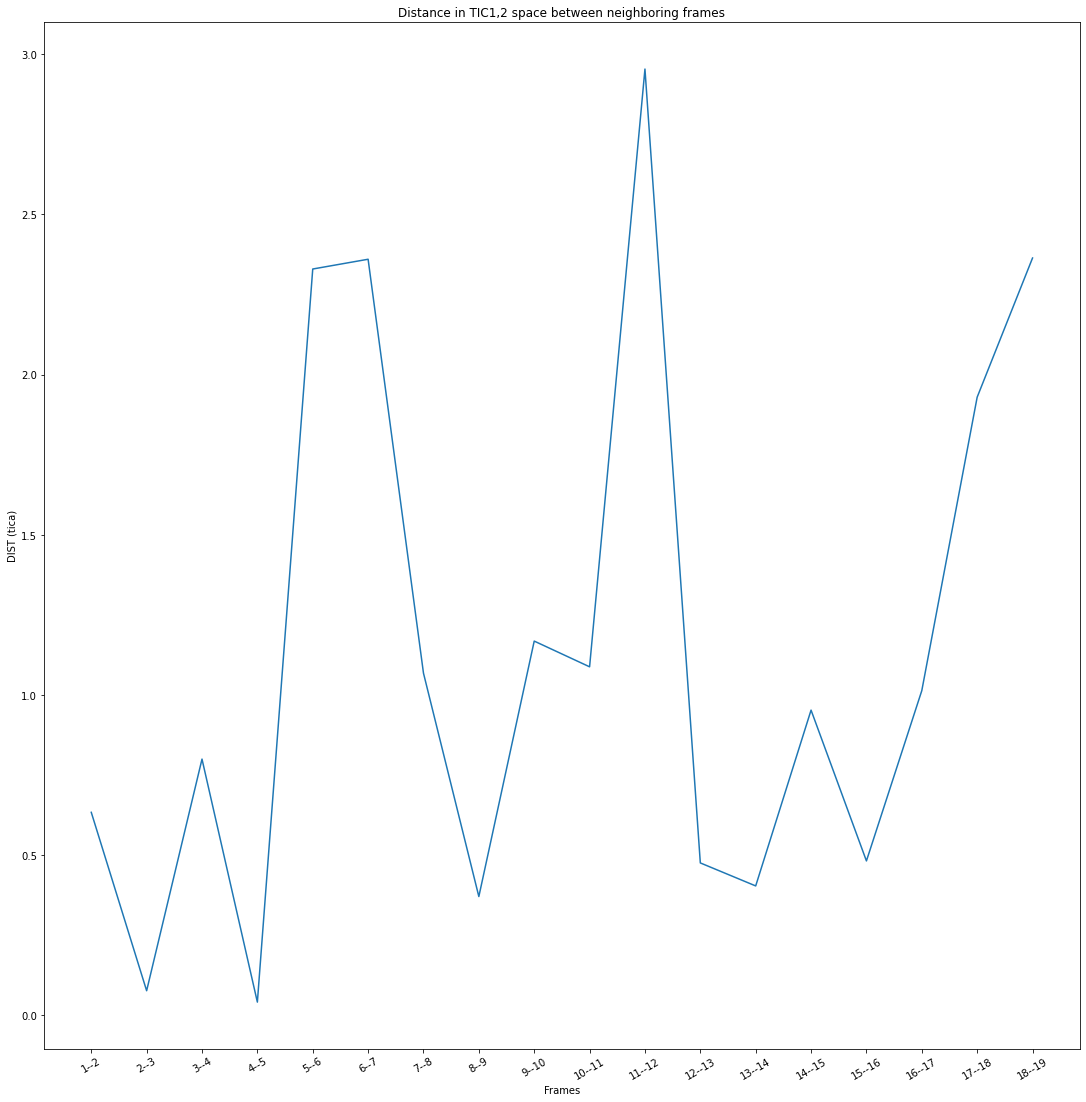

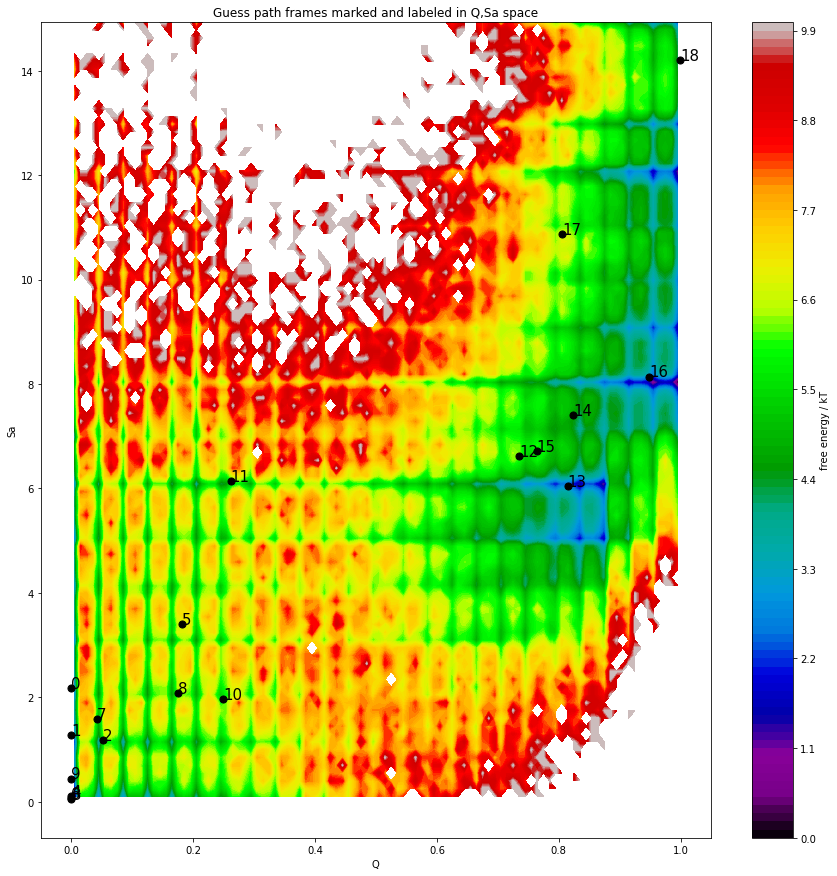

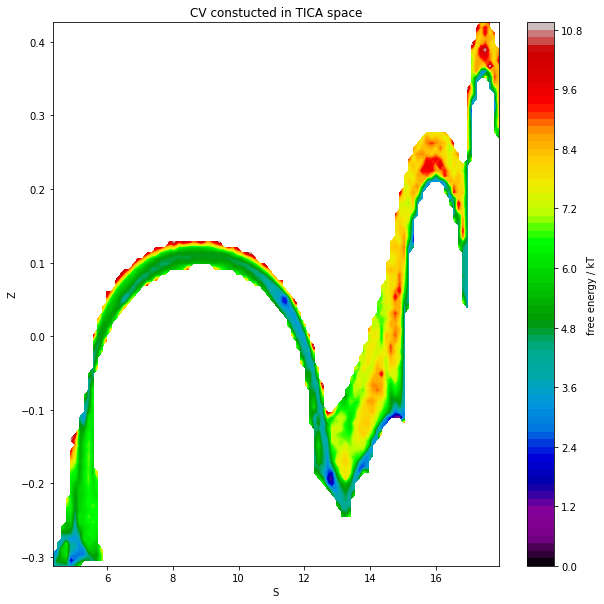

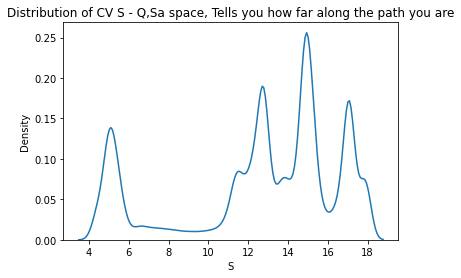

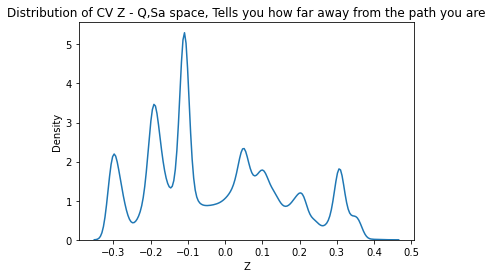

In [65]:
#let's try calculating a PCV in the space of Sa and Q
Q = np.load("/home/t/chem101/pcv/marvel-2/ntxd/QP_trunc.npy")
Sa = np.load("/home/t/chem101/pcv/marvel-2/ntxd/Sa_total_trunc.npy")
p = np.stack([Q,Sa],axis=1)
p_red = p

plt.figure()
tica_displacements = []
for i in range(len(path_frames)-1):
    tica_displacements.append(rmsd(p_red[path_frames[i]],p_red[path_frames[i+1]]))

fig,ax = plt.subplots(1,1,figsize=(15,15))
ax.plot(np.arange(1,len(tica_displacements)+1),tica_displacements)
ax.set_xticks(np.arange(1,1+len(tica_displacements)),[f"{i+1}--{i+2}" for i in range(len(tica_displacements))],rotation =30)
plt.tight_layout()
ax.set_title("Distance in TIC1,2 space between neighboring frames")
ax.set_ylabel("DIST (tica)")
ax.set_xlabel("Frames")



fig,ax = plt.subplots(1,1,figsize=(15,15))
pyemma.plots.plot_free_energy(*p_red.T,ax=ax)
ax.scatter(*p_red[path_frames].T,c="black",s=50)
for j,c in enumerate(path_frames):
    ax.annotate(text=f"{j}",xy=(p_red[c]),size=15,color="black")
ax.set_xlabel("Q")
ax.set_ylabel("Sa")
ax.set_title("Guess path frames marked and labeled in Q,Sa space")

xi = [p_red[i] for i in path_frames]
lam_ = lam(xi)
pathS = [S(x,xi,lam_) for x in p_red]
pathZ = [Z(x,xi,lam_) for x in p_red]

fig,ax = plt.subplots(1,1,figsize=(10,10))
pyemma.plots.plot_free_energy(pathS,pathZ,ax=ax)
ax.set_xlabel("S")
ax.set_ylabel("Z")
ax.set_title("CV constucted in TICA space")
plt.figure()
sns.kdeplot(pathS)
plt.title("Distribution of CV S - Q,Sa space, Tells you how far along the path you are")
plt.xlabel("S")

plt.figure()
sns.kdeplot(pathZ)
plt.title("Distribution of CV Z - Q,Sa space, Tells you how far away from the path you are")
plt.xlabel("Z")

##we see that the S CV has a distribution that represents each of our clusters in the path.

Text(0.5, 0, 'Z')

<Figure size 432x288 with 0 Axes>

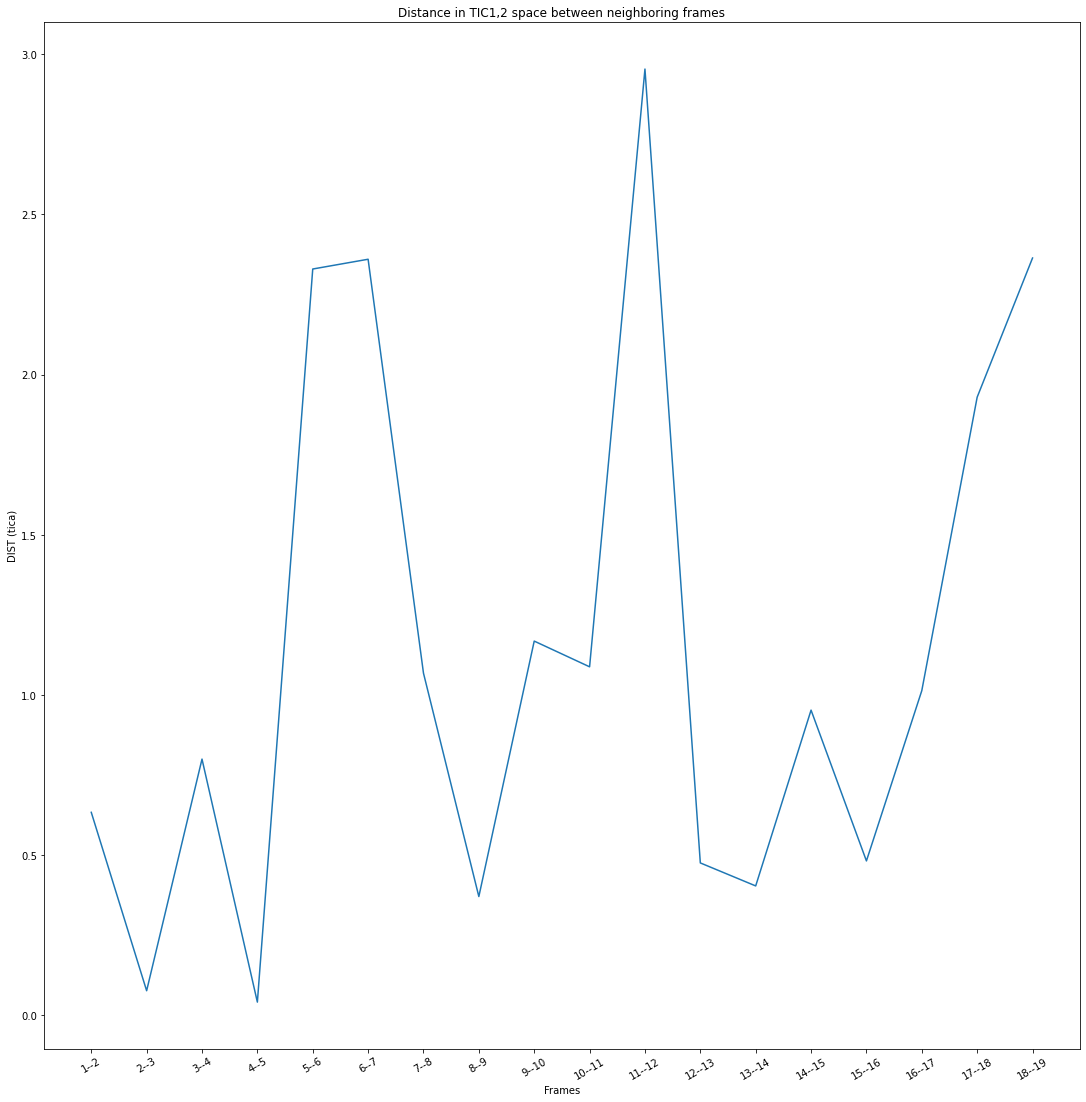

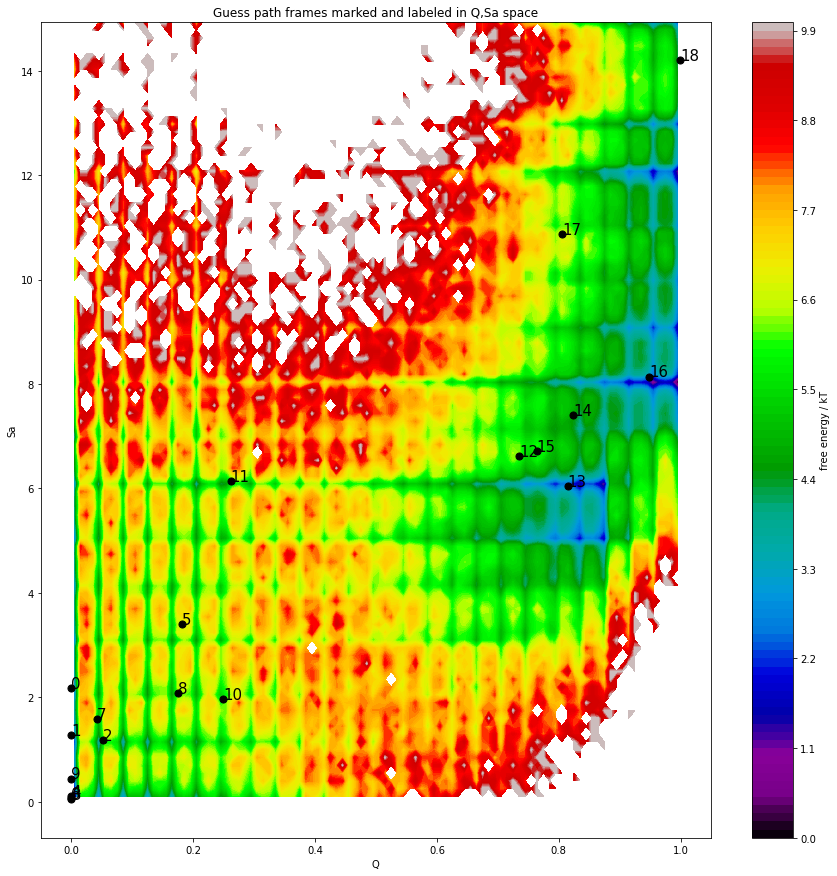

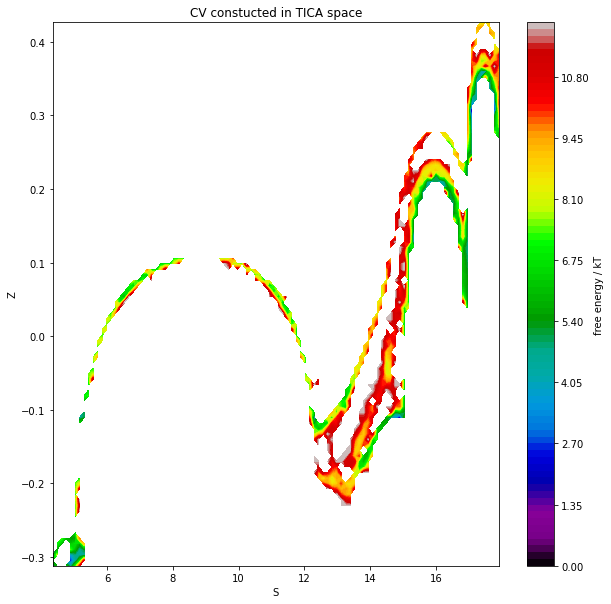

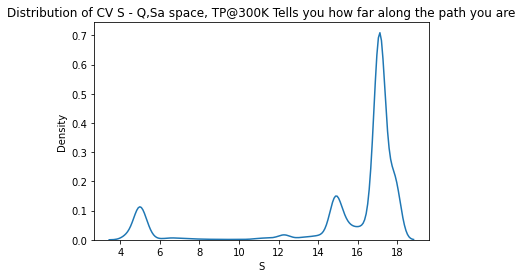

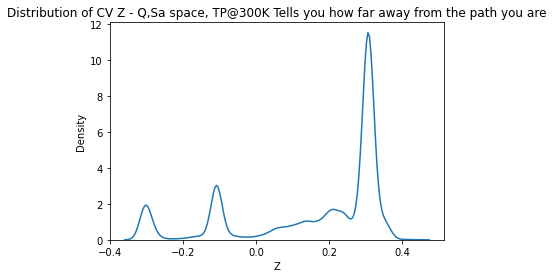

In [71]:
##lets calculate this same coordinate for one of our transition path trajectories at 300K


Q_tp = np.load("/home/t/chem101/pcv/marvel-2/ntxd/Qarr_para1.npy")
Sa_tp = np.load("/home/t/chem101/pcv/marvel-2/ntxd/SAarr_para1.npy")
inp = np.stack([Q_tp,np.sum(Sa_tp,axis=1)],axis=1)

plt.figure()
tica_displacements = []
for i in range(len(path_frames)-1):
    tica_displacements.append(rmsd(p_red[path_frames[i]],p_red[path_frames[i+1]]))

fig,ax = plt.subplots(1,1,figsize=(15,15))
ax.plot(np.arange(1,len(tica_displacements)+1),tica_displacements)
ax.set_xticks(np.arange(1,1+len(tica_displacements)),[f"{i+1}--{i+2}" for i in range(len(tica_displacements))],rotation =30)
plt.tight_layout()
ax.set_title("Distance in TIC1,2 space between neighboring frames")
ax.set_ylabel("DIST (tica)")
ax.set_xlabel("Frames")



fig,ax = plt.subplots(1,1,figsize=(15,15))
pyemma.plots.plot_free_energy(*p_red.T,ax=ax)
ax.scatter(*p_red[path_frames].T,c="black",s=50)
for j,c in enumerate(path_frames):
    ax.annotate(text=f"{j}",xy=(p_red[c]),size=15,color="black")
ax.set_xlabel("Q")
ax.set_ylabel("Sa")
ax.set_title("Guess path frames marked and labeled in Q,Sa space")

# xi = [p_red[i] for i in path_frames]
# lam_ = lam(xi)
pathS = [S(x,xi,lam_) for x in inp]
pathZ = [Z(x,xi,lam_) for x in inp]

fig,ax = plt.subplots(1,1,figsize=(10,10))
pyemma.plots.plot_free_energy(pathS,pathZ,ax=ax)
ax.set_xlabel("S")
ax.set_ylabel("Z")
ax.set_title("CV constucted in TICA space")
plt.figure()
sns.kdeplot(pathS)
plt.title("Distribution of CV S - Q,Sa space, TP@300K Tells you how far along the path you are")
plt.xlabel("S")

plt.figure()
sns.kdeplot(pathZ)
plt.title("Distribution of CV Z - Q,Sa space, TP@300K Tells you how far away from the path you are")
plt.xlabel("Z")